In [2]:
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
import json
from konlpy.tag import Okt
import pymysql.cursors
import pandas as pd
import re

In [3]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = 'select *,(pow(if(special_char_count = 0,1,special_char_count),2) + pow(if(manufacturer_count = 0,1,manufacturer_count),2) + pow(if(product_count = 0,1,product_count),2)) / if(review_len = 0, 1, review_len) as c1 from review_analyzing_data where review_len <> 0 and not isnull(review_score)'
        curs.execute(sql)
        result = curs.fetchall()
        df = pd.DataFrame(result)
finally:
    conn.close()

In [4]:
okt = Okt()

In [5]:
def tokenize(review):
    return ['/'.join(t) for t in okt.pos(review, norm=True, stem=True)]

In [126]:
import nltk

with open('review_token.json', encoding='utf-8') as f:
    review_token = json.load(f)

tokens = [t for d in review_token for t in d[0] if ((
    t.split('/')[1] == 'Noun') or (t.split('/')[1] == 'Adjective'))]

text = nltk.Text(tokens, name='NMSC')

print(len(set(text.tokens)))

34256


In [127]:
tokens_1 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '1')]

text_1 = nltk.Text(tokens_1, name='NMSC')

rating_1 = text_1.vocab().most_common(1000)

tokens_5 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '5')]
text_5 = nltk.Text(tokens_5, name='NMSC')

rating_5 = text_5.vocab().most_common(1000)

rating_1_word = [x[0] for x in rating_1]
rating_5_word = [x[0] for x in rating_5]

common_word = [x for x in rating_1_word if x in rating_5_word]

rating_1_word_not_common = [x for x in rating_1_word if x not in common_word]
rating_5_word_not_common = [x for x in rating_5_word if x not in common_word]

# tokens_1_word = [x for x in tokens_1 if x not in common_word]
# tokens_5_word = [x for x in tokens_5 if x not in common_word]

In [128]:
rating_1_count = []
for word,count in rating_1:
    if word in common_word:
        rating_1_count.append(count)
print(len(rating_1_count))

697


In [129]:
rating_5_count = []
for word,count in rating_5:
    if word in common_word:
        rating_5_count.append(count)
print(len(rating_5_count))

697


In [130]:
r = 19050/56990
rating_5_count = list(map(lambda x : x*r,rating_5_count))

In [131]:
r = 102.1/155.3
rating_5_count = list(map(lambda x : x*r,rating_5_count))

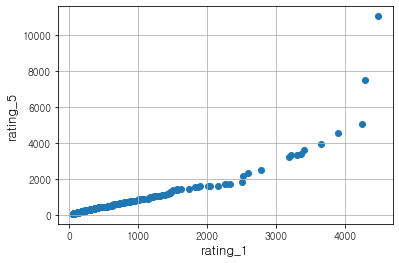

In [132]:
# 1점 리뷰에서 많이 쓰는 단어는 5점 리뷰에서도 많이 쓴다
plt.scatter(rating_1_count,rating_5_count)
plt.xlabel("rating_1", fontsize=13)
plt.ylabel("rating_5", fontsize=13)
plt.grid()
plt.show()

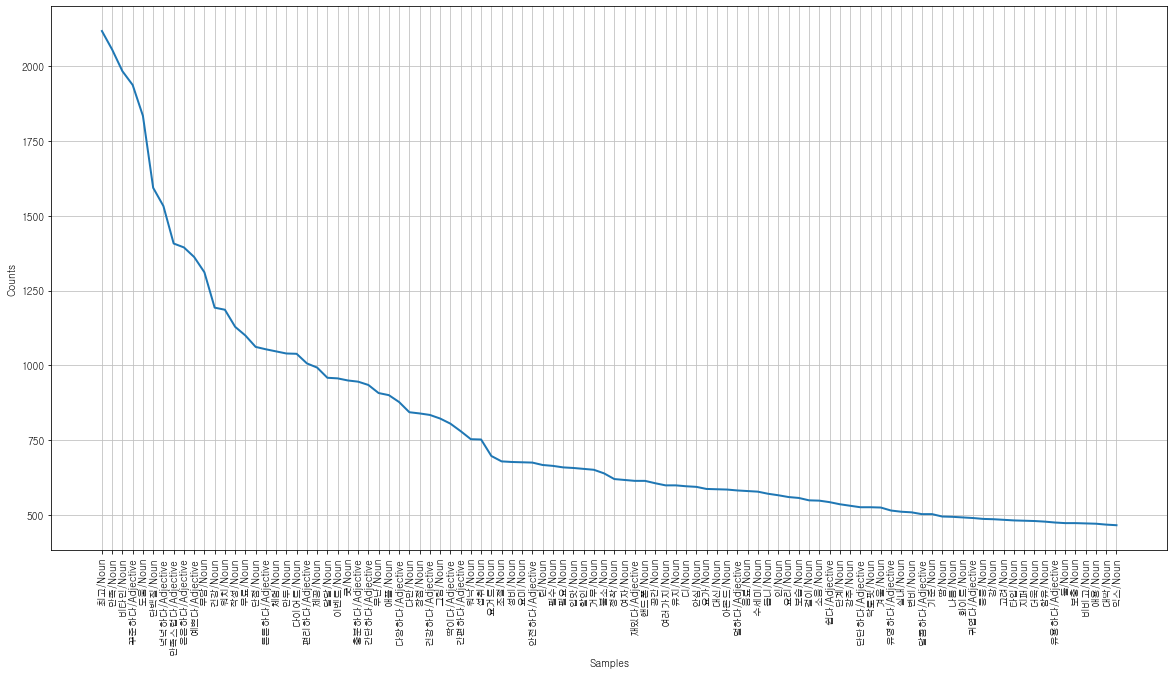

In [134]:
temp = [x for x in tokens_5 if x in rating_5_word_not_common]
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(20, 10))
nltk.Text(temp).plot(100)

In [135]:
selected_word = rating_5_word_not_common[0:200]
result = []
for d,_,_ in review_token:
    temp = []
    for word in selected_word:
        temp.append(d.count(word))
    result.append(temp)

In [136]:
result_df = pd.DataFrame(result)

In [137]:
result_df = result_df.replace(0,np.NaN)

In [138]:
result_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


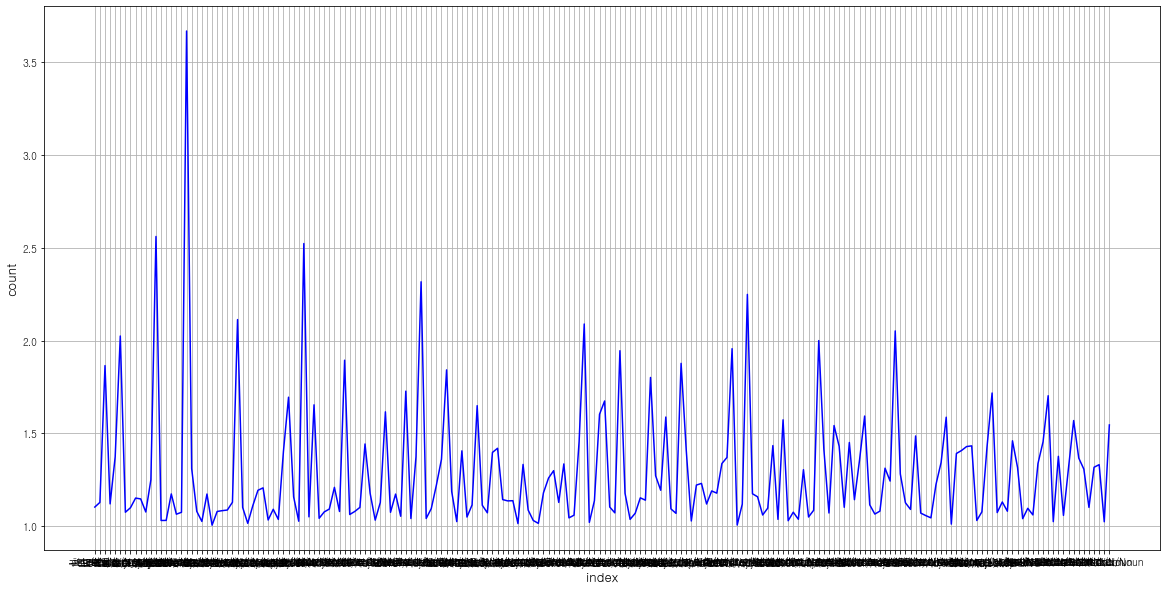

In [140]:
index_list = [i for i in range(200)]
plt.figure(figsize=(20, 10))
plt.plot(selected_word,result_df.mean(),color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.grid()
plt.show()

In [141]:
result_mean = result_df.mean()

In [142]:
result_index_mean = result_mean.index.where(result_mean>1.5).tolist()

In [143]:
result_index_mean = [x for x in result_index_mean if not np.isnan(x)]

In [144]:
for i in result_index_mean:
    print(selected_word[int(i)])

비타민/Noun
단백질/Noun
워치/Noun
만두/Noun
애플/Noun
요거트/Noun
요미/Noun
틴/Noun
불소/Noun
디/Noun
아몬드/Noun
수세미/Noun
걸이/Noun
락토핏/Noun
비비고/Noun
믹스/Noun
뉴트로지나/Noun
퓨저/Noun
시리얼/Noun
모발/Noun
주스/Noun
눈썹/Noun
록키스/Noun
종아리/Noun
패치/Noun
클린/Noun
상어/Noun
펄프/Noun
프린터/Noun
필/Noun
서울/Noun
정수기/Noun
고무장갑/Noun


In [145]:
rating_5_df = df[df['review_rating'] == 5]
rating_1_df = df[df['review_rating'] == 1]

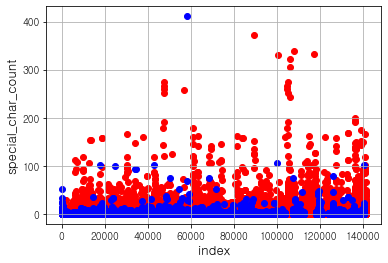

In [96]:
# 5점 리뷰와 1점 리뷰의 특수문자 개수
plt.scatter(rating_5_df.index,rating_5_df['special_char_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['special_char_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("special_char_count", fontsize=13)
plt.grid()
plt.show()

In [ ]:
plt.bar([1,5],[rating_1_df['special_char_count'].mean(),rating_5_df['special_char_count'].mean()])

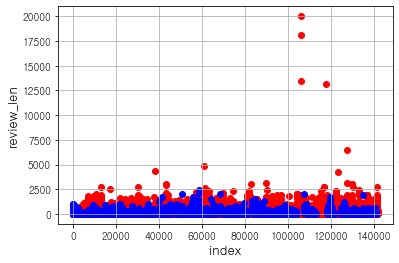

In [97]:
plt.scatter(rating_5_df.index,rating_5_df['review_len'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['review_len'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("review_len", fontsize=13)
plt.grid()
plt.show()

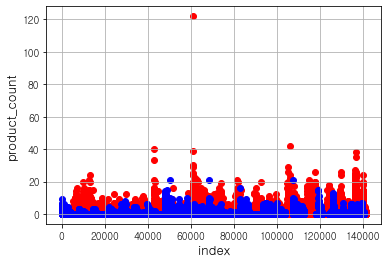

In [98]:
plt.scatter(rating_5_df.index,rating_5_df['product_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['product_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("product_count", fontsize=13)
plt.grid()
plt.show()

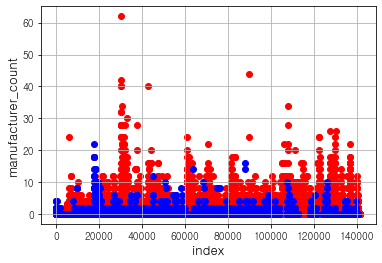

In [99]:
plt.scatter(rating_5_df.index,rating_5_df['manufacturer_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['manufacturer_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("manufacturer_count", fontsize=13)
plt.grid()
plt.show()

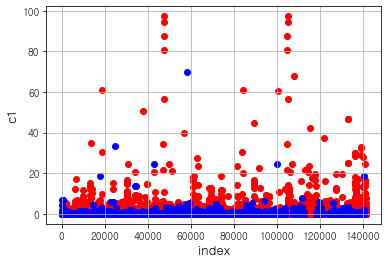

In [100]:
plt.scatter(rating_5_df.index,rating_5_df['c1'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['c1'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()

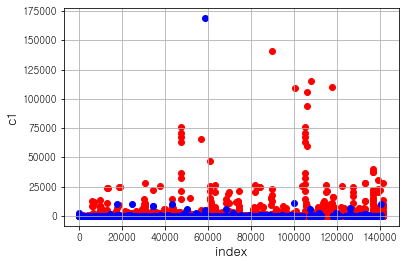

In [163]:
plt.scatter(rating_5_df.index,rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2,color='r')
plt.scatter(rating_1_df.index,rating_1_df['special_char_count']**2+rating_1_df['product_count']**2+rating_1_df['manufacturer_count']**2,color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()

In [164]:
rating_1_pms = rating_1_df[rating_1_df['special_char_count']**2+rating_1_df['product_count']**2+rating_1_df['manufacturer_count']**2<15000]

In [165]:
(rating_1_pms['special_char_count']**2+rating_1_pms['product_count']**2+rating_1_pms['manufacturer_count']**2).replace(0,np.NaN).mean()

32.2121736621953

In [166]:
rating_5_pms = rating_5_df[rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2>33]

In [167]:
(rating_5_pms['special_char_count']**2+rating_5_pms['product_count']**2+rating_5_pms['manufacturer_count']**2).replace(0,np.NaN).mean()

819.466803559206

In [168]:
rating_5_spam = rating_5_df[rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2>820]

In [170]:
rating_5_spam

,product_review_index,product_index,category_index,review_date,review_rating,newline_count,review_len,special_char_count,manufacturer_count,product_count,review_score,c1
1599,199,6663,6665,2021-06-01,5,37,669,29,2,0,99,1.264574
6252,797,61420,61422,2021-04-20,5,53,1035,112,8,5,99,12.205797
6295,801,61420,61422,2020-07-28,5,81,1297,87,24,9,99,6.342328
6336,805,61420,61422,2021-03-11,5,23,406,43,6,5,99,4.704433
6363,808,61420,61422,2020-03-16,5,21,378,34,2,2,99,3.079365
...,...,...,...,...,...,...,...,...,...,...,...,...
141385,24525,109393,86123,2021-03-02,5,41,763,49,0,2,99,3.153342
141391,24531,109393,86123,2021-05-28,5,43,784,66,0,1,99,5.558673
141394,24534,109393,86123,2021-05-30,5,14,266,45,0,0,83,7.620301
141422,24562,109393,86123,2021-05-24,5,18,662,42,0,0,99,2.667674


In [ ]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = """select * 
from product_review a 
left outer join review_content b 
on a.product_review_index = b.product_review_index 
and a.product_index = b.product_index
and a.category_index = b.category_index;"""
        curs.execute(sql)
        result = curs.fetchall()
        df = pd.DataFrame(result)
finally:
    conn.close()

In [ ]:
pd.merge(left=df,right=rating_5_spam, how='left', on=['product_review_index','product_index','category_index'])

In [169]:
rating_5_spam.to_csv('./maybe_spam.csv')